# Conformalised Quantile Regression

In the previous notebook, we obtained predictive bands with variable width by fitting an *additional* model to predict the absolute residuals produced by the *first* model. The advantage was that this could be done with *any* previously trained model and therefore has high practical relevance.

However, this is not the only way to obtain flexible prediction bands with Conformal Predictions. We can combine the two steps of target and residual prediction into one by fitting a quantile regression that we conformalize afterwards. This will be the topic of this notebook.

All we need to do is to train our predictive model using the pinball loss $\rho_q$ for every quantile $q \in \{\alpha/2, 1-\alpha/2, 0.5\}$:

$$
\rho_{q}(y, \hat{q}(x)) :=
\begin{cases}
    q(y-\hat{q}(x)), & \text{if } y-\hat{q}(x) > 0\\
    (1-q)(\hat{q}(x)-y), & \text{otherwise.}
\end{cases}
$$

where $(1-\alpha)$ is the target coverage level, $y$ are our labels, and $\hat{q}(x)$ is the $q$-quantile predictor to be learned.

In practice, this means that we need to (re-)train our regression model using this loss instead of e.g. a Mean-Squared-Error loss that would yield the predictive mean rather than the quantiles. Note that this may also change the optimization procedure since the pinball loss is not differentiable at $y-\hat{q}(x) = 0$.

The reference for conformalized quantile regression is the following:

*Romano, Y., Patterson, E., Candès, E. J. (2019). Conformalized Quantile Regression. NeurIPS 2019.*

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from util import regression_plot_with_uncertainty

This time we use a slightly different function for the prediction bands. The learned calibration score quantiles $s_{\alpha}$ are added to $\hat{q}_{1-\alpha/2}(x)$ and subtracted from $\hat{q}_{\alpha/2}(x)$.

In [2]:
def construct_prediction_bands(lower_predictions, upper_predictions, quantiles):
    """
    A function that returns the lower and upper prediction bands for every score quantile in quantiles.
    """
    
    prediction_bands = np.zeros((len(lower_predictions[0]), 2, len(quantiles)))

    for i, s in enumerate(quantiles):
        prediction_bands[:, :, i] = np.stack([
            lower_predictions[i] - s,
            upper_predictions[i] + s
        ], axis=1)

    return prediction_bands

## Generate Toy Dataset with Heteroscedastic Noise

We sample sinusoidal data with heteroscedastic noise with standard deviation $|x| * \sigma$, where $x$ consists of equally spaced inputs in the range $[-3, 3]$. $\sigma$ is a parameter for the initial noise standard deviation.

In [3]:
def f(x):
    """Polynomial function used to generate one-dimensional data."""
    return np.array(0.5*np.cos(2*np.pi/3*x) + 0.5)

In [4]:
def generate_heteroscedastic_data(n_samples, sigma=0.1, random_state=42):
    """
    Generate one-dimensional data from a given function,
    where a given noise standard deviation increases linearly with |x|.
    """
    np.random.seed(random_state)
    X = np.linspace(-3.0, 3.0, n_samples)[:, np.newaxis]
    y = f(X) + np.random.normal(0, sigma, (n_samples, 1)) * np.abs(X)
    y_gt = f(X)
    return X, y.ravel(), y_gt.ravel()

Let's generate the data for $\sigma=0.1$.

In [5]:
sigma = 0.1
X, y, y_gt = generate_heteroscedastic_data(n_samples=500, sigma=sigma, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Let's plot the ground-truth function and ground-truth 95% prediction intervals of the sampling distribution. We also add a couple of test points to the plot to verify that around 95% of them lie indeed inside the error bars.

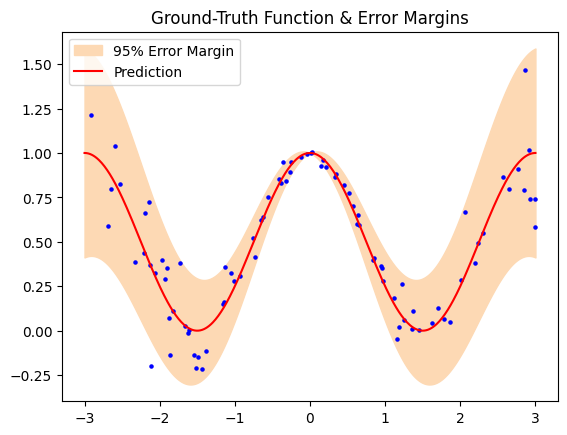

In [6]:
fig, ax = plt.subplots(1, 1)
# The 97.5th percentile of the standard normal distribution (for \sigma=1.0)
q975 = scipy.stats.norm.ppf(0.975)
# Since we sampled our data using y_gt + N(0, sigma) * |X|,
# the alpha=0.05 prediction bands should be [y_gt - sigma * q975 * |X|, y_gt + sigma * q975 * |X|]
# q025=-q975 for the standard normal distribution
prediction_bands = construct_prediction_bands(
    [y_gt - (q975 * sigma * np.abs(X)).ravel()],
    [y_gt + (q975 * sigma * np.abs(X)).ravel()],
    [0] # there is no correction term yet
)
regression_plot_with_uncertainty(ax, X, y_gt, prediction_bands, (X_cal, y_cal), labels=['95% Error Margin'])
ax.set_title('Ground-Truth Function & Error Margins')
plt.show()

Let's quickly verify that our ground-truth predictive bands capture around $95\%$ of the overall data.

In [9]:
def compute_coverage(y, prediction_bands):
    num_points_outside = np.sum((y < prediction_bands[:,0]) | (y > prediction_bands[:,1]))
    coverage_score = 1.0-num_points_outside/len(y)
    return coverage_score

In [10]:
total_coverage = compute_coverage(y, prediction_bands[:,:,0])

print(f"We have {total_coverage * 100:.2f}% coverage of all data points with our uncertainty bars.")

We have 95.60% coverage of all data points with our uncertainty bars.


## Fitting the Base Model

We will now move on to fitting the basic quantile regression model. Since our target function is sinusoidal, we extract [Random Fourier Features](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.RBFSampler.html) from our data and fit a simple [Linear Quantile Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.QuantileRegressor.html#sklearn.linear_model.QuantileRegressor) on top.

Alternatively, we could have chosen any non-linear model directly as long is it outputs regression quantiles. See [LGBMRegressor](https://lightgbm.readthedocs.io/en/stable/pythonapi/lightgbm.LGBMRegressor.html) with `objective="quantile"` for instance.

As stated before, we need to fit our model for the target quantiles $q \in \{\alpha/2, 1-\alpha/2, 0.5\}$ for every $\alpha$. Here we pick $\alpha \in \{0.05, 0.32\}$.

In [11]:
from sklearn.linear_model import QuantileRegressor
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import Pipeline

In [12]:
alphas = [0.05, 0.32]

# Let's collect all quantiles!
quantiles = [0.5]
for alpha in alphas:
    quantiles.extend([alpha/2, 1-alpha/2])

predictors = {}

for q in quantiles:
    predictor = Pipeline(
        [
            # We sample 16 random sinusoidal basis functions here
            ("sinusoidal_features", RBFSampler(gamma='scale', random_state=42, n_components=16)),
            ("regressor", QuantileRegressor(quantile=q, alpha=0, solver='highs')),
        ]
    )
    predictor.fit(X_train, y_train)
    # Let's store one predictor for every quantile
    predictors[q] = predictor

Without conformal predictions, our prediction bands look as follows. Note in particular that they do not need to be symmetric around the median prediction because the quantiles were fitted independently.

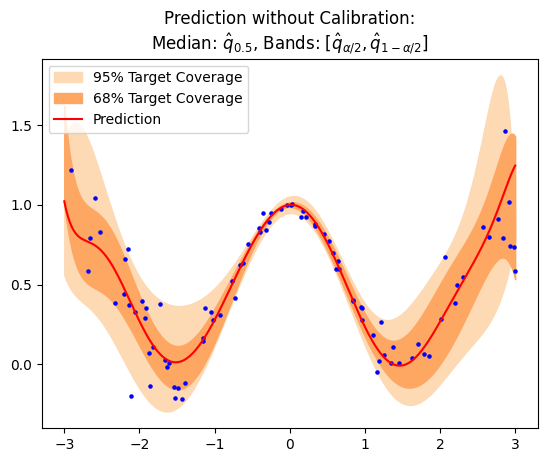

In [13]:
median_prediction = predictors[0.5].predict(X)
lower_predictions = [predictors[alpha/2].predict(X) for alpha in alphas]
upper_predictions = [predictors[1-alpha/2].predict(X) for alpha in alphas]

# Note that this time the prediction bands are independent from the (main) median predictor!
prediction_bands = construct_prediction_bands(lower_predictions, upper_predictions, [0.0]*len(alphas))

fig, ax = plt.subplots(1, 1)
regression_plot_with_uncertainty(
    ax, X, median_prediction, prediction_bands, (X_cal, y_cal),
    quantiles=1.0-np.array(alphas),
    labels=['95% Target Coverage', '68% Target Coverage']
)
ax.set_title('Prediction without Calibration:\n' +
             r'Median: $\hat{q}_{0.5}$, Bands: $[\hat{q}_{\alpha/2}, \hat{q}_{1-\alpha/2}]$')
plt.show()

Let's check the coverage on the calibration set for $\alpha=0.05$.

In [14]:
cal_lower_predictions = [predictors[alpha/2].predict(X_cal) for alpha in alphas]
cal_upper_predictions = [predictors[1-alpha/2].predict(X_cal) for alpha in alphas]

# Note that this time the prediction bands are independent from the (main) median predictor!
cal_prediction_bands = construct_prediction_bands(cal_lower_predictions, cal_upper_predictions, [0.0]*len(alphas))

cal_coverage = compute_coverage(y_cal, cal_prediction_bands[:,:,0])
print(f"Currently, we have {cal_coverage * 100:.2f}% coverage of the calibration points with our uncertainty bars.")

Currently, we have 91.11% coverage of the calibration points with our uncertainty bars.


## Calibrating the Base Model

The coverage is quite good already but slightly below 95%! In order to correct our bands, we need to estimate how much we need to stretch them. For this we compute the following scores on the calibration set:

$$
{\rm max} \{ \hat{q}_{\alpha/2}(x) - y, y - \hat{q}_{1-\alpha/2}(x) \}
$$

The scores can be seen as penalties. The left argument of the ${\rm max} \{ \cdot \}$ function grows with the lower bound; if it is larger than $y$, it also becomes positive. The right argument grows with a decreasing upper bound; if the upper bound is smaller than $y$, the value becomes positive.

Choosing the maximum of both values ensures that we calculate the required stretch that is necessary to move $y$ back into the bounds if this was not the case before. Otherwise, the score is negative to shrink these bounds. Taking the $(1-\alpha) (1 + 1/n_{\rm cal})$-quantile of the scores on the calibration set provides us with the correct stretch/shrink offset to capture $\approx (1 - \alpha)$ of the calibration points.

In [15]:
quantiles = []

for alpha in alphas:
    scores = np.max([
        predictors[alpha/2].predict(X_cal) - y_cal,
        y_cal - predictors[1-alpha/2].predict(X_cal)
    ], axis=0)
    # The (1 + (1 / len(X_cal)) factor is a small correction term ensuring theoretical guarantees
    quantiles.append(
        np.nanquantile(scores, (1 - alpha) * (1 + (1 / len(X_cal))), method='higher')
    )

In [16]:
print(f"The resulting quantiles are: {quantiles}")

The resulting quantiles are: [0.03718937464095318, -0.007437394619717264]


Let's plot the prediction bands using our calibration quantiles $s_{\alpha}$. For $\alpha=0.05$ the bands are stretched slightly, while they are minimally shrinked for $\alpha=0.32$.

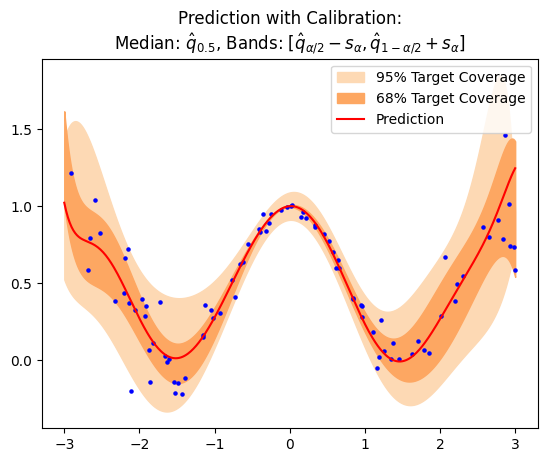

In [17]:
prediction_bands = construct_prediction_bands(lower_predictions, upper_predictions, quantiles)

fig, ax = plt.subplots(1, 1)
regression_plot_with_uncertainty(
    ax,
    X,
    median_prediction,
    prediction_bands,
    (X_cal, y_cal),
    quantiles=quantiles,
    labels=['95% Target Coverage', '68% Target Coverage']
)
ax.set_title('Prediction with Calibration:\n' +
             r'Median: $\hat{q}_{0.5}$, Bands: $[\hat{q}_{\alpha/2} - s_{\alpha}, \hat{q}_{1-\alpha/2} + s_{\alpha}]$')
plt.show()

Per design, we should have roughly ($1-\alpha$) coverage on the calibration and test sets. Let's double check!

In [18]:
for i, alpha, q in zip(list(range(len(quantiles))), alphas, quantiles):
    print()
    print(f'Alpha: {alpha} (Target coverage: {(1.0-alpha)*100:.2f}%)')
    print('-'*50)
    
    for data, label in zip([(X_cal, y_cal), (X_test, y_test)], ['calibration', 'test']):
        temp_lower_prediction = predictors[alpha/2].predict(data[0])
        temp_upper_prediction = predictors[1-alpha/2].predict(data[0])
        temp_prediction_bands = construct_prediction_bands([temp_lower_prediction], [temp_upper_prediction], [q])
        
        coverage = compute_coverage(data[1], temp_prediction_bands[:,:,0])
        print(f"Actual coverage on the {label} set: {coverage * 100:.2f}%")


Alpha: 0.05 (Target coverage: 95.00%)
--------------------------------------------------
Actual coverage on the calibration set: 96.67%
Actual coverage on the test set: 96.00%

Alpha: 0.32 (Target coverage: 68.00%)
--------------------------------------------------
Actual coverage on the calibration set: 70.00%
Actual coverage on the test set: 76.00%


## Comparison against MAPIE

Finally, we want to double check whether our implementation matches the one from MAPIE.

In [19]:
from mapie.regression import MapieQuantileRegressor
import warnings

y_pis = []

with warnings.catch_warnings():
    # supressing overlapping quantiles warning
    warnings.simplefilter("ignore")

    for alpha in alphas:
        mapie_cqr = MapieQuantileRegressor(
            # We need to use the order: [alpha/2, 1-alpha/2, 0.5]
            [predictors[alpha/2], predictors[1-alpha/2], predictors[0.5]],
            method="quantile",
            cv="prefit",
            alpha=alpha
        )
        
        mapie_cqr.fit(X_cal, y_cal, random_state=42)
        y_pred, y_pis_temp = mapie_cqr.predict(X)
        y_pis.append(y_pis_temp)

y_pis = np.concatenate(y_pis, axis=-1)

We filtered out user warnings in the above code. Otherwise, it can happen that some upper quantile predictions are lower than some lower ones and vice versa depending on the seed we use. The reason is that our synthetic data has zero noise at $x=0$. Depending on the quantile regression fit, it can happen that $\hat{q}_{0.025}$ and $\hat{q}_{0.975}$ do not precisely align in this region since quantile regression is just a fit that depends on the training data. Let's check how many of the values are actually concerned by this.

In [20]:
# The upper quantile should generally be larger than the lower one
print(((y_pis[:,1] - y_pis[:,0]) < 0).sum())

0


In our case things are fine! Lastly, we verify whether our manually computed prediction bands are indeed equal up to $\epsilon$.

In [21]:
epsilon = 1e-12
proportion_equal_vals = np.mean( np.abs(y_pis-prediction_bands) < epsilon )
print(f'{proportion_equal_vals*100:.2f}% of values are equal.')

100.00% of values are equal.


... and we verify the same visually!

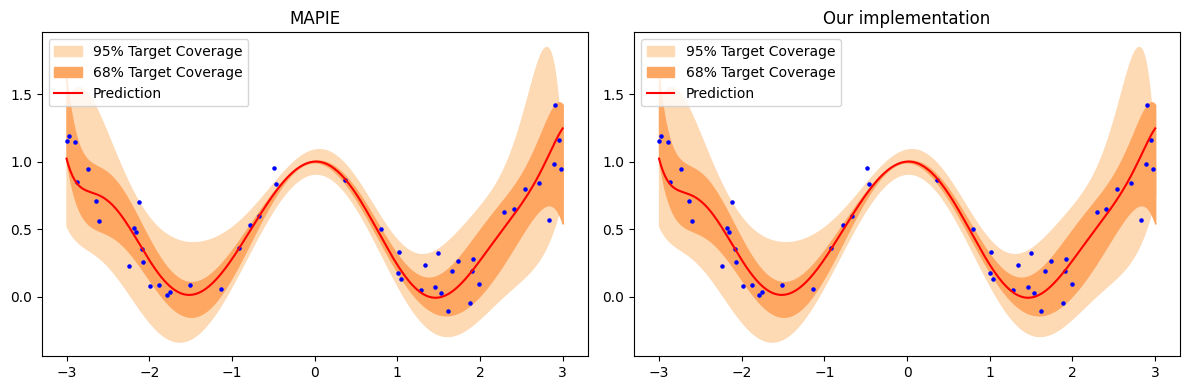

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
regression_plot_with_uncertainty(
    ax[0],
    X,
    y_pred,
    y_pis,
    (X_test, y_test),
    quantiles=quantiles,
    labels=['95% Target Coverage', '68% Target Coverage']
)

regression_plot_with_uncertainty(
    ax[1],
    X,
    median_prediction,
    prediction_bands,
    (X_test, y_test),
    quantiles=quantiles,
    labels=['95% Target Coverage', '68% Target Coverage']
)

ax[0].set_title('MAPIE')
ax[1].set_title('Our implementation')
plt.tight_layout()
plt.show()

And we're done! Conformal quantile regression is another very interesting approach for obtaining variable uncertainty bands with conformal predictions. An interesting difference to the previous notebook is that this time the predictive bands do not need to be symmetric around the main (median in this case) prediction. Moreover, the bands are fitted using the same model (just a different loss) as the median prediction. They are also learned independently and do not require the median predictor to be fitted first like we did in the previous notebook.